## ARCH and GARCH models

GARCH is used extensively within the financial industry as many asset prices are conditional heteroskedastic.

### Import required modules

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import data from Quandl

In [19]:
import quandl
quandl.ApiConfig.api_key = 'ZtrVMzQmPvx8zec1J4r9'

start = '2010-01-01'
end = '2017-01-01'

def get_price(symbol):
    data = quandl.get_table('WIKI/PRICES', ticker = symbol, 
                        qopts = { 'columns': ['Date','adj_close'] }, 
                        date = { 'gte': start, 'lte': end }, 
                        paginate=True)
    return data.set_index('date')

SPX = pd.read_csv('S&P.csv')
SPX = SPX[['Date', 'Adj Close']].set_index('Date')
SPX.columns = ['adj_close']
SPX = SPX[(SPX.index > start) & (SPX.index < end)]

def get_logreturns(data):
    return np.log(data/data.shift(1)).fillna(0).adj_close

### Function for time series analysis plots

In [20]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

## Autoregressive Conditionally Heteroskedastic Models - ARCH(p)
### ARCH(1) Model
### $$\epsilon_t=w_t\sqrt{\alpha_0+\alpha_1\epsilon_{t-1}^2}$$

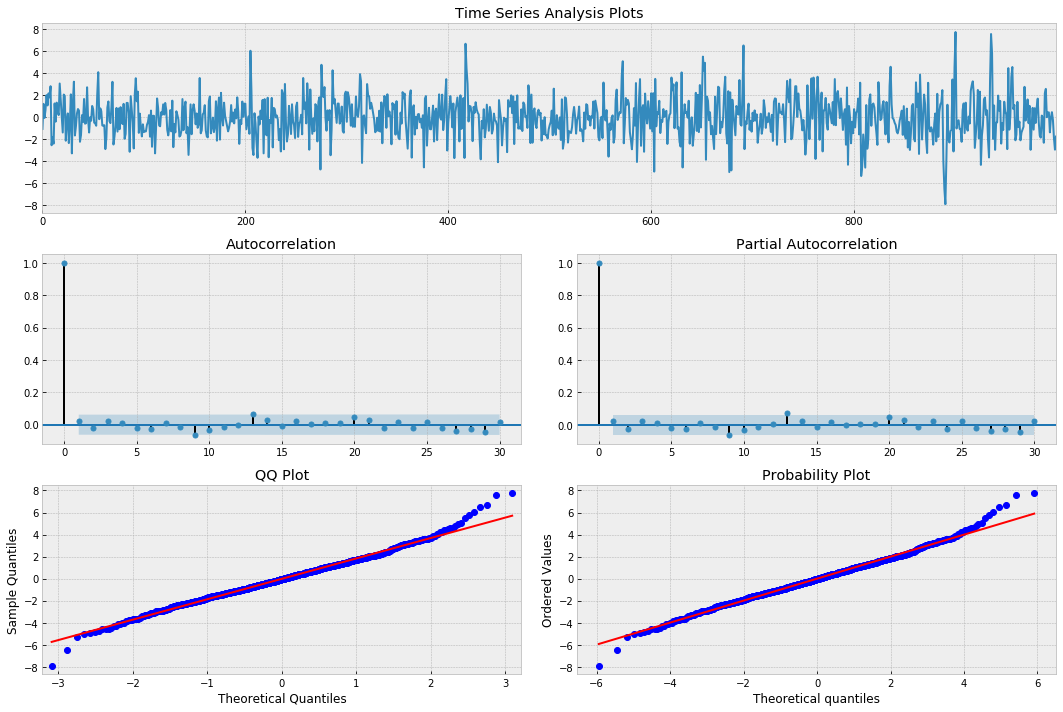

In [21]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(y, lags=30)

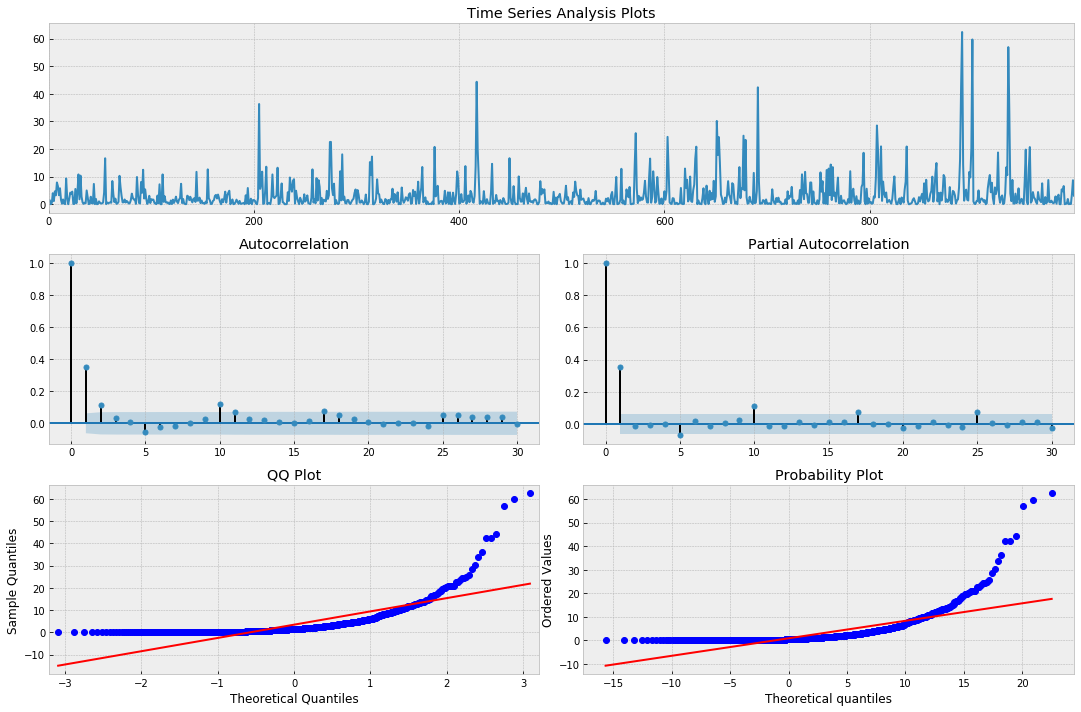

In [22]:
tsplot(y**2, lags=30)

## Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)
### $$\epsilon_t=\sigma_tw_t$$
### $$\sigma_t^2=\alpha_0+\sum_{i=1}^p\alpha_i\epsilon_{t-i}^2+\sum_{j=1}^q\beta_j\sigma_{t-j}^2$$
### GARCH(1,1)
### $$\sigma_t^2=\alpha_0+\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

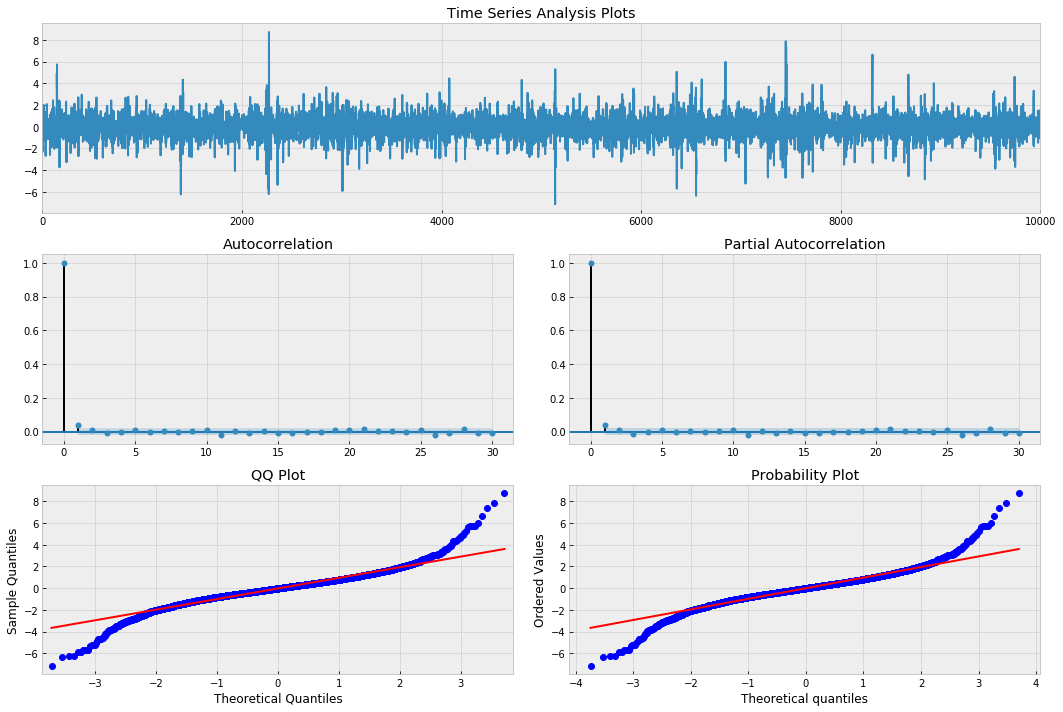

In [23]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

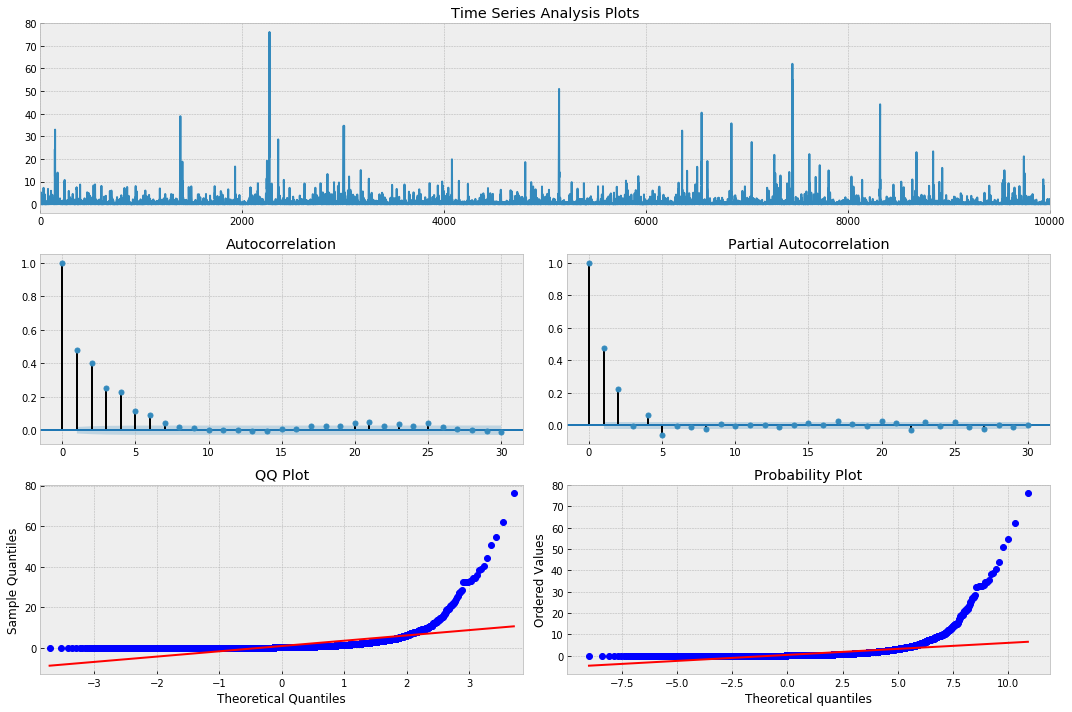

In [24]:
_ = tsplot(eps**2, lags=30)

In [25]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592659128462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.303267318555
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Wed, Jun 26 2019   Df Residuals:                     9996
Time:      

# Financial Time Series

Now apply the procedure to a financial time series. Here we're going to use SPX returns. The process is as follows:
1. Iterate through combinations of ARIMA(p, d, q) models to best fit our time series.
2. Pick the GARCH model orders according to the ARIMA model with lowest AIC.
3. Fit the GARCH(p, q) model to our time series.
4. Examine the model residuals and squared residuals for autocorrelation

In [26]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = get_logreturns(SPX)
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq='infer')
res_tup = _get_best_model(TS)

aic: -13139.60658 | order: (3, 1, 4)


In [28]:
order = res_tup[1]
model = res_tup[2]

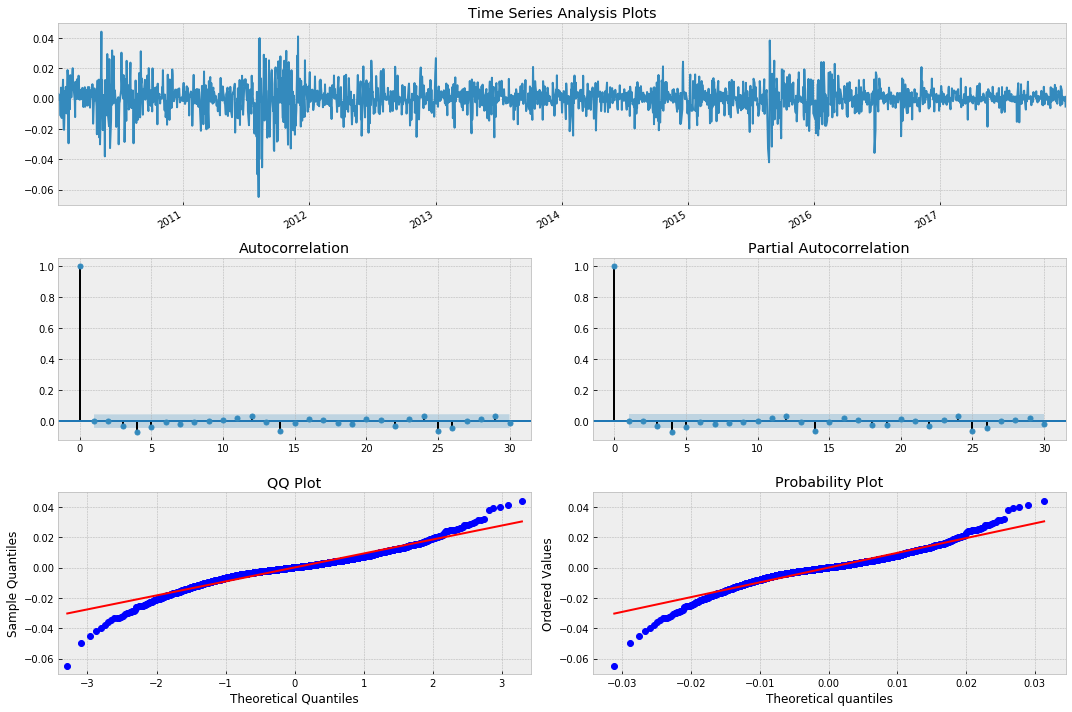

In [29]:
tsplot(model.resid, lags=30)

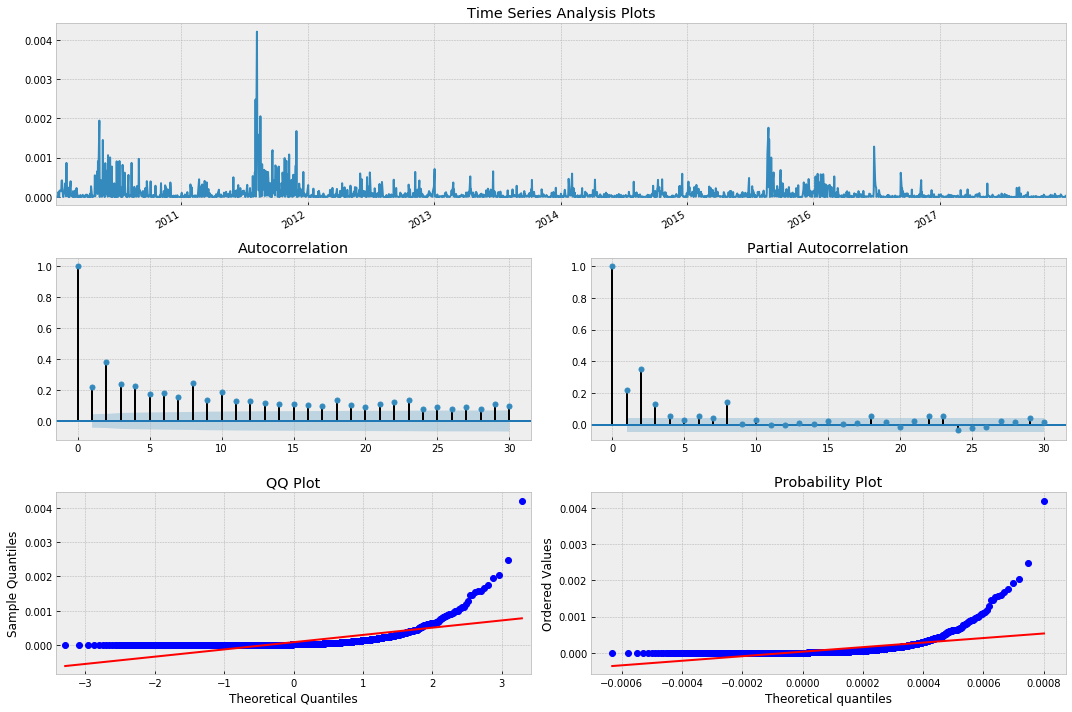

In [30]:
tsplot(model.resid**2, lags=30)

In [43]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                1037.74
Distribution:      Standardized Student's t   AIC:                          -2053.49
Method:                  Maximum Likelihood   BIC:                          -2014.71
                                              No. Observations:                  251
Date:                      Wed, Jun 26 2019   Df Residuals:                      240
Time:                              10:57:44   Df Model:                           11
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




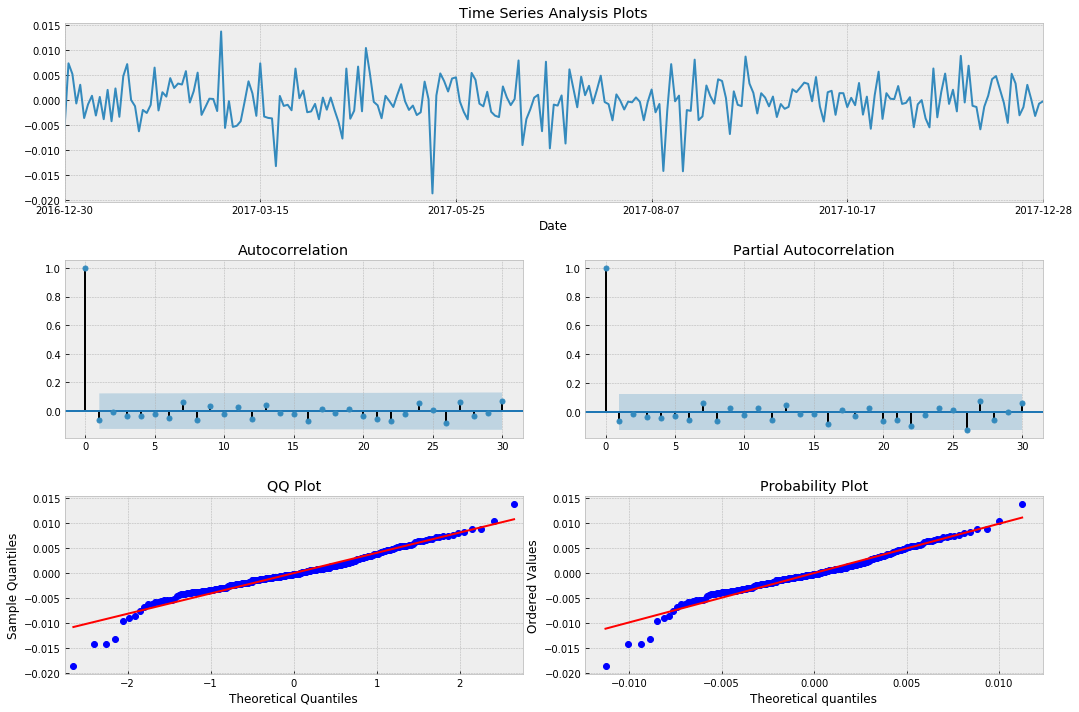

In [44]:
tsplot(res.resid, lags=30)

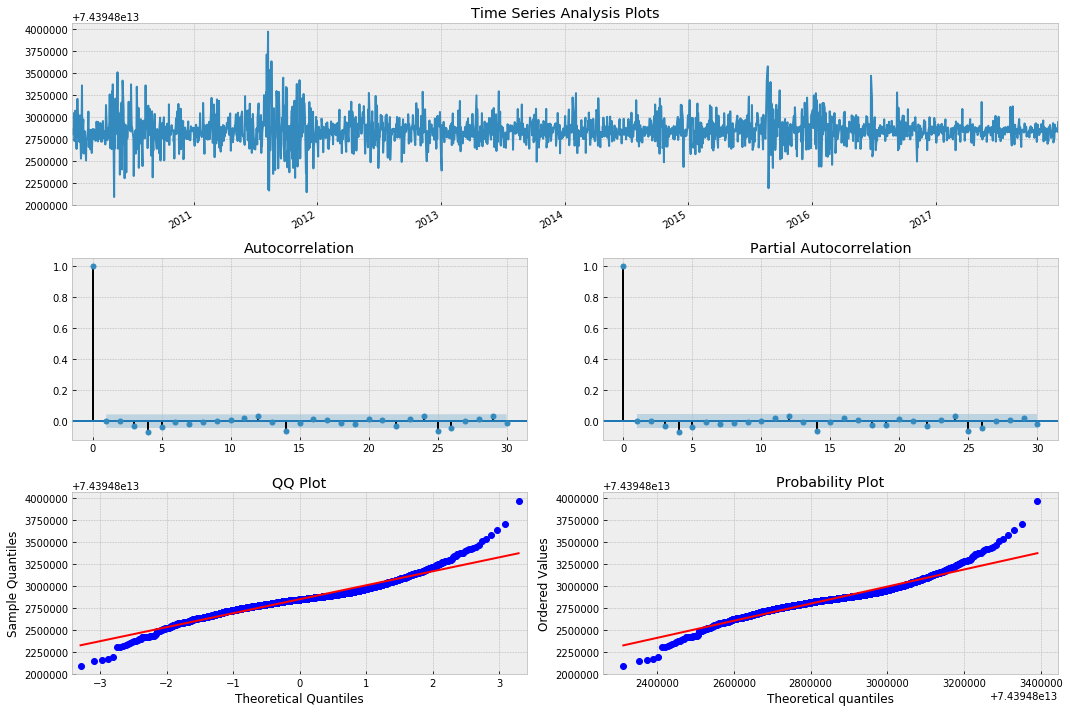

In [32]:
tsplot(res.resid**2, lags=30)

## Trading Strategy Implementation

In [45]:
windowLength = 252
foreLength = len(get_logreturns(SPX)) - windowLength
signal = 0*get_logreturns(SPX)[-foreLength:]

In [46]:
for d in range(foreLength):
    
    # create a rolling window by selecting 
    # values between d+1 and d+T of S&P500 returns
    try:
        TS = get_logreturns(SPX)[(1+d):(windowLength+d)] 

        # Find the best ARIMA fit 
        # set d = 0 since we've already taken log return of the series
        res_tup = _get_best_model(TS)
        order = res_tup[1]
        model = res_tup[2]

        #now that we have our ARIMA fit, we feed this to GARCH model
        p_ = order[0]
        o_ = order[1]
        q_ = order[2]

        am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
        res = am.fit(update_freq=5, disp='off')

        # Generate a forecast of next day return using our fitted model
        out = res.forecast(horizon=1, start=None, align='origin')

        #Set trading signal equal to the sign of forecasted return
        # Buy if we expect positive returns, sell if negative

        signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])
    except:
        pass

aic: -1533.36531 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1532.41521 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1532.40134 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1532.30413 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1532.28965 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1532.30205 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1532.87417 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1532.87178 | order: (0, 0, 1)
aic: -1532.25267 | order: (0, 0, 1)
aic: -1533.49617 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1534.15984 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1534.78783 | order: (0, 0, 1)
aic: -1539.32611 | order: (4, 0, 3)
aic: -1542.11675 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.27092 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1541.97201 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1541.20874 | order: (0, 0, 1)
aic: -1543.22538 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1544.45266 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1544.52002 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1544.29786 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1543.20252 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1550.98858 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1551.10718 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1551.79791 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1552.38855 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1552.20840 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1553.56106 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1553.59309 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1556.63463 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1556.68916 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1557.15361 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1556.96187 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1556.81927 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1555.01884 | order: (0, 0, 1)
aic: -1555.55690 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1555.08335 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1555.05768 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1554.16818 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1554.40180 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1552.75805 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1552.84141 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1549.43450 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1549.33106 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1548.96301 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1548.46240 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1548.95375 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1547.11700 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1547.12531 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1547.14765 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1546.04060 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1543.82115 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.44703 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.92981 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1538.00937 | order: (0, 0, 1)
aic: -1541.82489 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1538.16611 | order: (0, 0, 1)
aic: -1541.48690 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1541.45472 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1539.56437 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1541.24690 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.01041 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.39001 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1540.16142 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1539.06128 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.73653 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1539.77725 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1539.71555 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1539.60190 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1540.48313 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1540.04379 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.43984 | order: (2, 0, 2)
aic: -1542.56796 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1543.14407 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.05465 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.11796 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1540.04074 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1543.62257 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1546.41098 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1546.29200 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1546.19547 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1547.94068 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1547.21595 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1552.57490 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1553.51327 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1566.03700 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1562.64574 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1580.58439 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1581.94911 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1582.67156 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1581.08522 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1584.87525 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1584.04607 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1588.37781 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1588.45669 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1599.93434 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1603.19211 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1602.90183 | order: (2, 0, 1)
aic: -1602.60134 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1601.77986 | order: (2, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1615.95974 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1613.82090 | order: (0, 0, 1)
aic: -1617.00837 | order: (0, 0, 1)
aic: -1622.92316 | order: (0, 0, 1)
aic: -1620.79961 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1630.88961 | order: (0, 0, 1)
aic: -1631.91724 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1631.96173 | order: (0, 0, 1)
aic: -1633.64606 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1642.79874 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1641.88312 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1639.38374 | order: (0, 0, 1)
aic: -1645.88591 | order: (0, 0, 1)
aic: -1643.97922 | order: (0, 0, 1)
aic: -1640.25646 | order: (0, 0, 1)
aic: -1640.24207 | order: (0, 0, 1)
aic: -1640.31668 | order: (0, 0, 1)
aic: -1643.13010 | order: (0, 0, 1)
aic: -1641.09310 | order: (0, 0, 1)
aic: -1644.05674 | order: (0, 0, 1)
aic: -1644.05334 | order: (0, 0, 1)
aic: -1642.42796 | order: (0, 0, 1)
aic: -1654.26352 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1653.02369 | order: (0, 0, 1)
aic: -1652.23862 | order: (0, 0, 1)
aic: -1651.18562 | order: (0, 0, 1)
aic: -1649.00860 | order: (0, 0, 1)
aic: -1661.27538 | order: (0, 0, 1)
aic: -1662.47558 | order: (0, 0, 1)
aic: -1661.73679 | order: (0, 0, 1)
aic: -1662.22473 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1659.77129 | order: (0, 0, 1)
aic: -1659.43358 | order: (0, 0, 1)
aic: -1659.32350 | order: (0, 0, 1)
aic: -1671.98595 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1670.00231 | order: (0, 0, 1)
aic: -1672.23076 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1669.40489 | order: (0, 0, 1)
aic: -1676.27605 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1674.77163 | order: (0, 0, 1)
aic: -1676.44135 | order: (0, 0, 1)
aic: -1676.02856 | order: (0, 0, 1)
aic: -1676.46560 | order: (0, 0, 1)
aic: -1670.88069 | order: (0, 0, 1)
aic: -1670.69529 | order: (0, 0, 1)
aic: -1676.53437 | order: (0, 0, 1)
aic: -1676.59473 | order: (0, 0, 1)
aic: -1667.95892 | order: (0, 0, 1)
aic: -1667.67975 | order: (0, 0, 1)
aic: -1637.81060 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1639.89872 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1595.41067 | order: (2, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1591.18959 | order: (0, 0, 4)
aic: -1588.00305 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1584.08944 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1573.78314 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1576.26816 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1576.13438 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1578.20005 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1563.04926 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1558.48600 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1558.12921 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1550.24594 | order: (1, 0, 2)
aic: -1548.40918 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1547.18811 | order: (3, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1548.72709 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1540.25261 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1545.36362 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1546.72953 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1547.06409 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1541.55480 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1541.77529 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1534.27687 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1533.85582 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1526.37139 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1525.57604 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1524.93347 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1524.04395 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1521.62161 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1522.68943 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1521.82776 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1522.56002 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1516.82676 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1511.05114 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1510.53203 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1506.70476 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1506.48353 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1503.53051 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1503.12004 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1500.03452 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1495.20621 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1489.73725 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1488.57801 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1487.17322 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1487.11388 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1481.19774 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1481.75889 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1482.22799 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1482.19471 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1481.65225 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1481.88797 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1480.97465 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1480.77479 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1480.68122 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1475.81315 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1475.59121 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1473.89460 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1473.32055 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1466.03813 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1466.04133 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1464.11094 | order: (4, 0, 2)
aic: -1459.22366 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1459.83171 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1458.06484 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1457.44939 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1457.59154 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1457.08710 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1448.58166 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1448.94850 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1446.79321 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1447.11624 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1446.40613 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1444.97078 | order: (1, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1440.83958 | order: (3, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1440.96519 | order: (3, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1439.02354 | order: (3, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1439.64782 | order: (3, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1437.96273 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1437.93102 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1431.99002 | order: (3, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1434.56231 | order: (3, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1425.74905 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1426.13629 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1426.05444 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1423.76958 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1423.79583 | order: (2, 0, 1)
aic: -1423.86154 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1421.50433 | order: (3, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1420.25631 | order: (3, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1419.52205 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1418.75047 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1418.65125 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1418.65202 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1418.48638 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.70203 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.55153 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.43286 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.15276 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.44839 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.45163 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.83119 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.62255 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.16983 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.20306 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.27161 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.29934 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.30972 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.33790 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1410.88032 | order: (2, 0, 1)
aic: -1411.24337 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.23753 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.47821 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.43872 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.24420 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.14602 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.17380 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.36950 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.36850 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.19170 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.08302 | order: (2, 0, 1)
aic: -1412.95071 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.35526 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.64751 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.21720 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.23927 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.31688 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.55365 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.62379 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.58697 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.58641 | order: (2, 0, 1)
aic: -1413.63815 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.48093 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.49685 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.35117 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.79836 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.76324 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.92647 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.06870 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.01739 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.67328 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.84595 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.42417 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.35016 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1418.68121 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1418.93958 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1419.32157 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1419.09301 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1419.05389 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1419.69063 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1419.81731 | order: (2, 0, 1)
aic: -1419.84692 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1419.47694 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1421.09011 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1421.69286 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1421.79370 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.88877 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.96577 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.94523 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1423.26145 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1423.28586 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.14156 | order: (2, 0, 1)
aic: -1422.42446 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.41630 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.42401 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.48552 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.16464 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1422.07855 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1421.50217 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1421.53179 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1420.98398 | order: (2, 0, 1)
aic: -1419.35888 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1419.25762 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1418.10678 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.23780 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.26593 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.43759 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.49234 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.28141 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.35895 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.01265 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.37047 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.46955 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.32175 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.34469 | order: (2, 0, 1)
aic: -1416.29818 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.17843 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.55173 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.44702 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.22605 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.48618 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.64270 | order: (2, 0, 1)
aic: -1415.79662 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.84026 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1416.08295 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.67738 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.50171 | order: (2, 0, 1)
aic: -1415.80105 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.68072 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.76685 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.98232 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.99752 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.12566 | order: (2, 0, 1)
aic: -1414.09528 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.31947 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.09750 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.82224 | order: (2, 0, 1)
aic: -1415.72207 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.87086 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.26619 | order: (2, 0, 1)
aic: -1413.81206 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.85331 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.16540 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.49172 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.10011 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.52076 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.67009 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1415.54448 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.46178 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.71311 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.78465 | order: (1, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.86420 | order: (1, 0, 2)
aic: -1411.90877 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.45274 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.00950 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.84610 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.25336 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.68031 | order: (2, 0, 1)
aic: -1410.59786 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1410.57135 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1410.52965 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.07659 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1410.58798 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.69144 | order: (2, 0, 1)
aic: -1412.36213 | order: (2, 0, 1)
aic: -1412.36171 | order: (2, 0, 1)
aic: -1412.34432 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.21435 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1411.43204 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.55886 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.14465 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.48794 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.14010 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.58313 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1412.79736 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.32119 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1414.96016 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1413.49553 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1417.75467 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1418.61561 | order: (3, 0, 3)
aic: -1420.24936 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1424.51356 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1424.34922 | order: (3, 0, 2)
aic: -1440.24383 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1451.50096 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1462.79437 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1475.13013 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1475.04249 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1477.26500 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1478.39612 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1478.44006 | order: (2, 0, 1)
aic: -1492.43699 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1489.70644 | order: (2, 0, 1)
aic: -1495.70860 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1497.78118 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1499.51270 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1500.41394 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1501.44895 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1506.22146 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1506.22024 | order: (2, 0, 1)
aic: -1513.83786 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1506.87389 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1511.05305 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1511.54504 | order: (2, 0, 1)
aic: -1517.30814 | order: (4, 0, 2)
aic: -1514.78381 | order: (0, 0, 1)
aic: -1520.00694 | order: (0, 0, 1)
aic: -1520.08664 | order: (0, 0, 1)
aic: -1520.63993 | order: (0, 0, 1)
aic: -1521.98472 | order: (0, 0, 1)
aic: -1522.21421 | order: (0, 0, 1)
aic: -1522.30970 | order: (0, 0, 1)
aic: -1522.97002 | order: (0, 0, 1)
aic: -1522.99201 | order: (0, 0, 1)
aic: -1536.76339 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1538.31248 | order: (0, 0, 1)
aic: -1538.71696 | order: (0, 0, 1)
aic: -1543.14401 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1542.96358 | order: (0, 0, 1)
aic: -1546.11170 | order: (0, 0, 1)
aic: -1547.92622 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1551.57721 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1558.05087 | order: (1, 0, 0)
aic: -1562.68507 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1565.69805 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1567.98923 | order: (0, 0, 1)
aic: -1568.33447 | order: (0, 0, 1)
aic: -1578.76335 | order: (1, 0, 1)
aic: -1577.91741 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1578.58528 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1578.60105 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1581.39127 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1583.32450 | order: (0, 0, 1)
aic: -1586.11679 | order: (0, 0, 1)
aic: -1587.50030 | order: (0, 0, 1)
aic: -1587.65992 | order: (0, 0, 1)
aic: -1588.64612 | order: (0, 0, 4)
aic: -1591.41054 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1593.95970 | order: (0, 0, 4)
aic: -1594.06466 | order: (0, 0, 4)
aic: -1609.17227 | order: (0, 0, 4)
aic: -1609.22304 | order: (0, 0, 4)
aic: -1618.27266 | order: (0, 0, 4)
aic: -1624.21259 | order: (0, 0, 4)
aic: -1627.30347 | order: (0, 0, 4)
aic: -1628.28979 | order: (0, 0, 4)
aic: -1627.87239 | order: (0, 0, 4)
aic: -1624.38023 | order: (0, 0, 4)
aic: -1622.16346 | order: (0, 0, 4)
aic: -1640.35728 | order: (4, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1640.58003 | order: (4, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1642.25743 | order: (4, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1639.70620 | order: (4, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1639.68436 | order: (4, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1644.10544 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1643.43357 | order: (4, 0, 1)
aic: -1643.39061 | order: (4, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1644.98390 | order: (0, 0, 4)
aic: -1642.38869 | order: (4, 0, 1)
aic: -1648.92810 | order: (0, 0, 2)
aic: -1648.44959 | order: (0, 0, 2)
aic: -1656.98983 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1656.85194 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1682.78235 | order: (3, 0, 2)
aic: -1682.41261 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1682.35387 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1683.63386 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1683.45367 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1683.41950 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1691.18653 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1692.28883 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1697.45908 | order: (3, 0, 2)
aic: -1697.71586 | order: (3, 0, 2)
aic: -1697.36825 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1696.78531 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1694.76996 | order: (3, 0, 2)
aic: -1695.85374 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1707.77149 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1707.03309 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1708.00884 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1709.28584 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1709.28054 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1709.43436 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1707.36278 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1698.91574 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.80806 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.12237 | order: (3, 0, 2)
aic: -1702.18772 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.40368 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1701.94693 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1701.91489 | order: (3, 0, 2)
aic: -1701.94117 | order: (3, 0, 2)
aic: -1702.02768 | order: (3, 0, 2)
aic: -1701.99664 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.52862 | order: (3, 0, 2)
aic: -1704.05672 | order: (3, 0, 2)
aic: -1704.07477 | order: (3, 0, 2)
aic: -1702.47102 | order: (0, 0, 1)
aic: -1703.54471 | order: (3, 0, 2)
aic: -1703.58160 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.26364 | order: (3, 0, 2)
aic: -1704.52638 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.17883 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.12751 | order: (0, 0, 1)
aic: -1703.80307 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.68265 | order: (0, 0, 1)
aic: -1701.23723 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1701.89039 | order: (0, 0, 1)
aic: -1702.84403 | order: (3, 0, 2)
aic: -1702.84597 | order: (3, 0, 2)
aic: -1702.39547 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.43947 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.07970 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.85075 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.85499 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.36217 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1705.57057 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.28437 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1701.51640 | order: (0, 0, 1)
aic: -1700.48402 | order: (0, 0, 1)
aic: -1695.46608 | order: (0, 0, 1)
aic: -1695.96826 | order: (3, 0, 2)
aic: -1693.74577 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1693.69064 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1694.08246 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1694.79595 | order: (2, 0, 2)
aic: -1692.92054 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1692.93193 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1696.47857 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1696.92327 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1698.12423 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1698.33289 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1699.24146 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.17481 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.19817 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.19574 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.13183 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.56133 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1701.46659 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1700.72100 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1701.42388 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1701.66057 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1706.53092 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.34191 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1706.47824 | order: (3, 0, 2)
aic: -1704.33615 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.73595 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.73632 | order: (3, 0, 2)
aic: -1704.94923 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1705.82645 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1705.78648 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.89280 | order: (3, 0, 2)
aic: -1708.43691 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1709.55824 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.75765 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.42575 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.37060 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.50964 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.92806 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.94883 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.31584 | order: (3, 0, 2)
aic: -1703.95893 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.03780 | order: (3, 0, 2)
aic: -1706.84517 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1705.60843 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1705.15903 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1704.57812 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1703.71540 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.19120 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1702.89910 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1706.60354 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1706.19402 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1707.11550 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1708.25282 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1708.15794 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1706.86083 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1708.67343 | order: (3, 0, 2)
aic: -1708.46596 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1706.90562 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1710.67374 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1711.27540 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1714.16933 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1714.12141 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1714.12095 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1713.83224 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1713.00187 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1714.63582 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1713.42066 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1712.90343 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1721.96827 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1718.53637 | order: (4, 0, 0)
aic: -1718.53833 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1724.79010 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1724.77340 | order: (4, 0, 0)
aic: -1724.49573 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1724.24426 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1721.93268 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1723.62965 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1723.91219 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1723.28415 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1721.35585 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1710.38420 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1710.30912 | order: (0, 0, 1)
aic: -1715.90376 | order: (0, 0, 1)
aic: -1715.38336 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1717.89763 | order: (0, 0, 1)
aic: -1717.63745 | order: (0, 0, 1)
aic: -1718.64503 | order: (0, 0, 1)
aic: -1718.23326 | order: (0, 0, 1)
aic: -1728.34000 | order: (0, 0, 1)
aic: -1728.44019 | order: (0, 0, 1)
aic: -1727.32707 | order: (0, 0, 1)
aic: -1727.23208 | order: (0, 0, 1)
aic: -1727.86372 | order: (0, 0, 1)
aic: -1727.91419 | order: (0, 0, 1)
aic: -1725.97649 | order: (0, 0, 1)
aic: -1725.80000 | order: (0, 0, 1)
aic: -1726.16788 | order: (0, 0, 1)
aic: -1730.47527 | order: (0, 0, 1)
aic: -1730.43542 | order: (0, 0, 1)
aic: -1730.94069 | order: (0, 0, 1)
aic: -1731.65925 | order: (0, 0, 1)
aic: -1731.71120 | order: (0, 0, 1)
aic: -1733.43725 | order: (0, 0, 1)
aic: -1734.60709 | order: (0, 0, 1)
aic: -1735.93843 | order: (0, 0, 1)
aic: -1735.92532 | order: (0, 0, 1)
aic: -1740.74724 | order: (0, 0, 1)
aic: -1747.18272 | order: (0, 0, 1)
aic: -1747.19037 | order: (0, 0, 1)
aic: -1744.72535 | order: (0, 0, 1)
aic: -1744.82514 | order: (0, 0, 1)
aic: -1745.64411 | order: (0

C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1735.67472 | order: (0, 0, 1)
aic: -1735.18588 | order: (0, 0, 1)
aic: -1735.31855 | order: (0, 0, 1)
aic: -1739.65606 | order: (0, 0, 1)
aic: -1739.27904 | order: (0, 0, 1)
aic: -1742.92379 | order: (0, 0, 1)
aic: -1742.72784 | order: (0, 0, 1)
aic: -1742.84941 | order: (0, 0, 1)
aic: -1742.29444 | order: (0, 0, 1)
aic: -1741.89384 | order: (0, 0, 1)
aic: -1743.65704 | order: (0, 0, 1)
aic: -1745.10589 | order: (0, 0, 1)
aic: -1744.96397 | order: (0, 0, 1)
aic: -1745.86967 | order: (0, 0, 1)
aic: -1757.20968 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1755.96624 | order: (0, 0, 1)
aic: -1752.91181 | order: (0, 0, 1)
aic: -1752.88127 | order: (0, 0, 1)
aic: -1755.17610 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1757.65514 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1757.55130 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1755.47355 | order: (0, 0, 1)
aic: -1762.70226 | order: (0, 0, 1)
aic: -1762.61807 | order: (0, 0, 1)
aic: -1762.52358 | order: (0, 0, 1)
aic: -1765.19777 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1764.04780 | order: (0, 0, 1)
aic: -1764.47991 | order: (0, 0, 1)
aic: -1765.75681 | order: (0, 0, 1)
aic: -1765.99165 | order: (0, 0, 1)
aic: -1765.98368 | order: (0, 0, 1)
aic: -1766.29731 | order: (0, 0, 1)
aic: -1766.12639 | order: (0, 0, 1)
aic: -1766.14483 | order: (0, 0, 1)
aic: -1765.99433 | order: (0, 0, 1)
aic: -1763.82637 | order: (0, 0, 1)
aic: -1763.71759 | order: (0, 0, 1)
aic: -1764.37175 | order: (0, 0, 1)
aic: -1762.29135 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1762.21666 | order: (0, 0, 1)
aic: -1762.45235 | order: (0, 0, 1)
aic: -1764.69296 | order: (0, 0, 1)
aic: -1766.97796 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1762.73162 | order: (0, 0, 1)
aic: -1763.20693 | order: (0, 0, 1)
aic: -1765.18174 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1764.07949 | order: (0, 0, 1)
aic: -1764.34687 | order: (0, 0, 1)
aic: -1763.93640 | order: (0, 0, 1)
aic: -1766.03046 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1772.66499 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1785.25383 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1783.74166 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1784.17500 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1784.27795 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1783.74281 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1783.96002 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1785.17329 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1785.05802 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1781.77941 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1779.82999 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1779.07390 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1779.78316 | order: (1, 0, 0)
aic: -1779.74743 | order: (0, 0, 1)
aic: -1780.05644 | order: (0, 0, 1)
aic: -1780.09350 | order: (0, 0, 1)
aic: -1778.46517 | order: (0, 0, 1)
aic: -1769.36428 | order: (0, 0, 1)
aic: -1768.61832 | order: (0, 0, 1)
aic: -1768.42859 | order: (0, 0, 1)
aic: -1766.80641 | order: (0, 0, 1)
aic: -1764.69788 | order: (0, 0, 1)
aic: -1766.63504 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1757.40842 | order: (0, 0, 1)
aic: -1758.71566 | order: (0, 0, 1)
aic: -1758.66789 | order: (0, 0, 1)
aic: -1755.84513 | order: (0, 0, 1)
aic: -1752.79216 | order: (0, 0, 1)
aic: -1752.70281 | order: (0, 0, 1)
aic: -1750.45520 | order: (0, 0, 1)
aic: -1750.46134 | order: (0, 0, 1)
aic: -1749.84555 | order: (0, 0, 1)
aic: -1749.38430 | order: (0, 0, 1)
aic: -1750.21042 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.43860 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.48631 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1753.65285 | order: (0, 0, 1)
aic: -1759.31170 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1760.07911 | order: (1, 0, 0)
aic: -1763.16645 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1762.70397 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1762.65507 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1762.08008 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1759.57626 | order: (1, 0, 0)
aic: -1759.59535 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1759.61630 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1760.01873 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1760.20468 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1759.90354 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1760.03209 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1758.08107 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1757.76900 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.65128 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.55821 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1755.70086 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.24665 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1757.04493 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.75508 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1757.55452 | order: (0, 0, 1)
aic: -1756.65748 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.85974 | order: (0, 0, 1)
aic: -1756.82017 | order: (0, 0, 1)
aic: -1756.04405 | order: (0, 0, 1)
aic: -1757.16248 | order: (0, 0, 1)
aic: -1757.29484 | order: (0, 0, 1)
aic: -1757.61086 | order: (0, 0, 1)
aic: -1755.34268 | order: (0, 0, 1)
aic: -1753.34130 | order: (0, 0, 1)
aic: -1755.87581 | order: (0, 0, 1)
aic: -1753.86623 | order: (0, 0, 1)
aic: -1746.01362 | order: (0, 0, 1)
aic: -1756.02613 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.71119 | order: (0, 0, 1)
aic: -1759.79442 | order: (0, 0, 1)
aic: -1758.68474 | order: (0, 0, 1)
aic: -1760.11296 | order: (0, 0, 1)
aic: -1760.21583 | order: (0, 0, 1)
aic: -1761.98608 | order: (0, 0, 1)
aic: -1761.88261 | order: (0, 0, 1)
aic: -1763.48809 | order: (4, 0, 4)
aic: -1762.47984 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.65854 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1761.39635 | order: (0, 0, 1)
aic: -1763.02846 | order: (0, 0, 1)
aic: -1764.63849 | order: (0, 0, 1)
aic: -1766.74977 | order: (0, 0, 1)
aic: -1767.47440 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1765.64073 | order: (0, 0, 1)
aic: -1765.33680 | order: (0, 0, 1)
aic: -1765.57275 | order: (0, 0, 1)
aic: -1765.89272 | order: (0, 0, 1)
aic: -1764.08150 | order: (0, 0, 1)
aic: -1766.05240 | order: (0, 0, 1)
aic: -1766.14059 | order: (0, 0, 1)
aic: -1764.96586 | order: (0, 0, 1)
aic: -1766.73628 | order: (0, 0, 1)
aic: -1766.46869 | order: (0, 0, 1)
aic: -1765.68019 | order: (0, 0, 1)
aic: -1765.69890 | order: (0, 0, 1)
aic: -1765.76798 | order: (0, 0, 1)
aic: -1765.42843 | order: (0, 0, 1)
aic: -1765.56861 | order: (0, 0, 1)
aic: -1766.55180 | order: (0, 0, 1)
aic: -1766.30512 | order: (0, 0, 1)
aic: -1770.50949 | order: (0, 0, 1)
aic: -1771.25430 | order: (0, 0, 1)
aic: -1771.74989 | order: (0, 0, 1)
aic: -1775.77625 | order: (0, 0, 1)
aic: -1776.21946 | order: (0, 0, 1)
aic: -1779.18345 | order: (0, 0, 1)
aic: -1779.17126 | order: (0, 0, 1)
aic: -1781.21178 | order: (0, 0, 1)
aic: -1782.63621 | order: (0, 0, 1)
aic: -1786.38087 | order: (0, 0, 1)
aic: -1786.96541 | order: (0

C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1814.03776 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1815.97954 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1816.74710 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1814.86124 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1814.86047 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1816.77338 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1817.21361 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1817.67022 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1817.21091 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1819.11616 | order: (4, 0, 3)
aic: -1821.13455 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1820.61558 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1821.06590 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1821.28926 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1818.79201 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1815.05205 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1814.48645 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1813.70598 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1813.92108 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1814.07903 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1813.56068 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1812.71814 | order: (0, 0, 1)
aic: -1812.87373 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1812.87584 | order: (4, 0, 2)
aic: -1807.48399 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1806.18466 | order: (0, 0, 1)
aic: -1805.04643 | order: (0, 0, 1)
aic: -1803.64005 | order: (0, 0, 1)
aic: -1803.96871 | order: (0, 0, 1)
aic: -1803.59801 | order: (0, 0, 1)
aic: -1800.91872 | order: (0, 0, 1)
aic: -1800.76128 | order: (0, 0, 1)
aic: -1800.87124 | order: (0, 0, 1)
aic: -1801.50916 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1804.82293 | order: (0, 0, 1)
aic: -1805.09226 | order: (0, 0, 1)
aic: -1804.21858 | order: (0, 0, 1)
aic: -1803.93920 | order: (0, 0, 1)
aic: -1804.54762 | order: (0, 0, 1)
aic: -1806.05410 | order: (0, 0, 1)
aic: -1806.31792 | order: (0, 0, 1)
aic: -1806.20422 | order: (0, 0, 1)
aic: -1812.15064 | order: (0, 0, 1)
aic: -1812.33143 | order: (0, 0, 1)
aic: -1812.35223 | order: (0, 0, 1)
aic: -1812.32822 | order: (0, 0, 1)
aic: -1812.74794 | order: (0, 0, 1)
aic: -1814.29675 | order: (0, 0, 1)
aic: -1814.27473 | order: (0, 0, 1)
aic: -1813.67778 | order: (0, 0, 1)
aic: -1816.00020 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1816.15019 | order: (0, 0, 1)
aic: -1816.07031 | order: (0, 0, 1)
aic: -1817.11049 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1815.65460 | order: (0, 0, 1)
aic: -1816.44547 | order: (0, 0, 1)
aic: -1815.62170 | order: (0, 0, 1)
aic: -1819.07182 | order: (0, 0, 1)
aic: -1818.58541 | order: (0, 0, 1)
aic: -1820.25390 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1818.90311 | order: (0, 0, 1)
aic: -1820.65689 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1820.48987 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1811.10615 | order: (0, 0, 1)
aic: -1815.05751 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1812.61285 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1814.16272 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1808.90506 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1809.84676 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1808.32432 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1814.60613 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1807.74100 | order: (0, 0, 1)
aic: -1801.69439 | order: (0, 0, 1)
aic: -1804.52742 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1801.26562 | order: (0, 0, 1)
aic: -1796.33047 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1797.40284 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1799.78866 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1800.11678 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1797.28699 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1795.62676 | order: (3, 0, 3)
aic: -1788.79475 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1788.17151 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1784.57732 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1782.69100 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1782.72773 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1780.39870 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1785.36445 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1780.43966 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1781.39797 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1777.85227 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1777.82057 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1779.83735 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1780.41344 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1784.16930 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1783.96997 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1784.04481 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1785.48552 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1786.01562 | order: (1, 0, 0)
aic: -1786.36496 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1786.66117 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1786.19699 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1786.81490 | order: (3, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1788.68722 | order: (3, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1787.70733 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1787.53603 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1787.51483 | order: (1, 0, 0)
aic: -1787.48085 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1787.37248 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1786.50810 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1785.95229 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1785.64967 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1785.94531 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1788.60902 | order: (1, 0, 0)
aic: -1787.55009 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1787.84018 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1784.88168 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1784.90632 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1779.84360 | order: (0, 0, 3)
aic: -1779.62049 | order: (0, 0, 3)
aic: -1778.38957 | order: (0, 0, 3)
aic: -1775.22901 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.26829 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.27040 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.53653 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.64531 | order: (1, 0, 0)
aic: -1764.08279 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.87159 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.85639 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.68237 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1763.12251 | order: (1, 0, 0)
aic: -1763.12206 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.69059 | order: (1, 0, 0)
aic: -1755.90495 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1753.35686 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1747.61302 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1746.34544 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1748.19684 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1750.17957 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1750.06043 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1748.54649 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1745.47720 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1745.58529 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1745.19622 | order: (1, 0, 0)
aic: -1742.41999 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.93953 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1750.25981 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1747.60379 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1746.29727 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1746.89856 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1744.45522 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.19934 | order: (1, 0, 0)
aic: -1748.52679 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1748.26581 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.11228 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.14430 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.85300 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.02078 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.02149 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1750.94283 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.04953 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.02238 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.80771 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.45924 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.83082 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1753.27377 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.43045 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.41984 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.83687 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.81342 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1753.37775 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1757.08606 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.72004 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.74820 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.90755 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.62305 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1747.69728 | order: (1, 0, 0)
aic: -1747.62282 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1747.30274 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1746.78934 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1745.26544 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1746.00444 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1744.04384 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1744.30441 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1743.24266 | order: (0, 0, 2)
aic: -1743.50925 | order: (0, 0, 2)
aic: -1743.05563 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1740.06806 | order: (0, 0, 2)
aic: -1740.11018 | order: (0, 0, 2)
aic: -1740.26491 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1738.76658 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1738.51576 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1738.20152 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1738.03747 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1740.26932 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1742.20879 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1743.03642 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1745.13774 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1753.55674 | order: (0, 0, 2)
aic: -1755.04085 | order: (0, 0, 2)
aic: -1756.46796 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1757.66192 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1759.42418 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.75589 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1755.21515 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1755.69882 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1755.30501 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1755.29540 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.55766 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.55447 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.72555 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1756.62113 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1754.40276 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.50145 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1752.19008 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.32486 | order: (0, 0, 2)
aic: -1749.24190 | order: (0, 0, 2)
aic: -1748.94883 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1746.63693 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.61120 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.57056 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.48765 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.36704 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.42330 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.24043 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1748.18008 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.74021 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.84729 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1751.89078 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1750.54412 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.18603 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1750.11982 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.28703 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.21416 | order: (2, 0, 2)
aic: -1749.32648 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.23760 | order: (2, 0, 2)
aic: -1749.18455 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1749.55015 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1748.66913 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1748.67709 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1745.32659 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1745.58953 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1744.30053 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1744.09399 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1742.61498 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1743.36427 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1741.61211 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1741.26718 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1740.68490 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1741.34037 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1741.32766 | order: (2, 0, 2)
aic: -1741.27516 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1741.28327 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1732.93756 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1733.57938 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1732.73008 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1733.20235 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1733.26987 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1733.48055 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.18441 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.44088 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1726.88084 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1724.93116 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1724.55544 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1724.76686 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1725.90255 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1727.59534 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1727.66079 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1727.79188 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1727.73429 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1727.21039 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1725.54179 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1724.91267 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1724.66055 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1721.83222 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1728.73405 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1728.76468 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.43726 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1730.96504 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1730.80549 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1730.26785 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1732.39083 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.76839 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1728.35412 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.14179 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.43563 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.18291 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.98137 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1730.32242 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1729.23456 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1721.55116 | order: (1, 0, 0)
aic: -1704.81827 | order: (1, 0, 0)
aic: -1684.90953 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1682.63755 | order: (2, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1661.97096 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1660.22341 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1658.99433 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1657.39987 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1649.60988 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1640.80735 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1640.77272 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1637.22248 | order: (2, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1630.90347 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1629.16816 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1628.80812 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1629.23071 | order: (3, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1629.11571 | order: (3, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1628.05898 | order: (4, 0, 0)
aic: -1627.10347 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1627.44823 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1624.54475 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1624.73259 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1625.28027 | order: (3, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1623.99051 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1630.65081 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1631.10471 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1622.98565 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1623.02810 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1619.68028 | order: (0, 0, 4)
aic: -1619.69274 | order: (0, 0, 4)
aic: -1619.41744 | order: (0, 0, 4)
aic: -1615.42670 | order: (0, 0, 4)
aic: -1620.43152 | order: (0, 0, 4)
aic: -1623.50946 | order: (0, 0, 4)
aic: -1626.99906 | order: (0, 0, 4)
aic: -1628.07318 | order: (0, 0, 4)
aic: -1630.38943 | order: (0, 0, 4)
aic: -1630.39114 | order: (0, 0, 4)
aic: -1630.44385 | order: (0, 0, 4)
aic: -1627.60255 | order: (0, 0, 4)
aic: -1630.05237 | order: (0, 0, 4)
aic: -1631.12190 | order: (0, 0, 4)
aic: -1636.42478 | order: (0, 0, 4)
aic: -1636.65908 | order: (0, 0, 4)
aic: -1634.80927 | order: (0, 0, 4)
aic: -1634.73739 | order: (0, 0, 4)
aic: -1634.69771 | order: (0, 0, 4)
aic: -1636.94199 | order: (0, 0, 4)
aic: -1633.82353 | order: (0, 0, 4)
aic: -1634.27918 | order: (0, 0, 4)
aic: -1636.03540 | order: (0, 0, 4)
aic: -1633.95670 | order: (0, 0, 4)
aic: -1633.77046 | order: (0, 0, 4)
aic: -1634.04389 | order: (0, 0, 4)
aic: -1634.25188 | order: (0, 0, 4)
aic: -1634.18538 | order: (0

C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1614.62951 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1614.63951 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1616.52412 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1619.15183 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1617.09373 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1616.31814 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1615.58646 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1614.63241 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1614.50954 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1614.62248 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1613.39724 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1614.36431 | order: (4, 0, 0)
aic: -1613.73336 | order: (4, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1614.62231 | order: (0, 0, 4)
aic: -1615.44442 | order: (0, 0, 4)
aic: -1613.29850 | order: (0, 0, 4)
aic: -1609.46963 | order: (0, 0, 4)
aic: -1608.65086 | order: (0, 0, 4)
aic: -1609.13503 | order: (0, 0, 4)
aic: -1609.09246 | order: (0, 0, 4)
aic: -1601.33183 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1598.09667 | order: (0, 0, 1)
aic: -1594.70339 | order: (0, 0, 1)
aic: -1594.70472 | order: (0, 0, 1)
aic: -1593.49439 | order: (0, 0, 1)
aic: -1595.52862 | order: (0, 0, 1)
aic: -1591.91677 | order: (0, 0, 1)
aic: -1589.36416 | order: (0, 0, 1)
aic: -1589.07548 | order: (0, 0, 1)
aic: -1589.70929 | order: (0, 0, 1)
aic: -1590.30342 | order: (0, 0, 1)
aic: -1586.24876 | order: (0, 0, 1)
aic: -1587.77913 | order: (0, 0, 1)
aic: -1586.32891 | order: (0, 0, 1)
aic: -1586.23987 | order: (0, 0, 1)
aic: -1587.24322 | order: (0, 0, 1)
aic: -1583.99710 | order: (0, 0, 1)
aic: -1582.36589 | order: (0, 0, 1)
aic: -1583.43952 | order: (0, 0, 1)
aic: -1583.44011 | order: (0, 0, 1)
aic: -1582.83892 | order: (0, 0, 1)
aic: -1579.36149 | order: (0, 0, 1)
aic: -1577.02260 | order: (0, 0, 1)
aic: -1574.71969 | order: (0, 0, 1)
aic: -1574.47718 | order: (0, 0, 1)
aic: -1574.82198 | order: (0, 0, 1)
aic: -1572.93573 | order: (0, 0, 1)
aic: -1571.45964 | order: (0, 0, 1)
aic: -1571.25443 | order: (0

C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1573.20087 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1573.64351 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1573.63737 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1574.01480 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1574.20805 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1574.41384 | order: (2, 0, 2)
aic: -1573.83391 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1575.03928 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1574.99110 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1574.97036 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1576.58857 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1577.14138 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1575.18245 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1574.04329 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1574.96132 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1573.96607 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1572.32341 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1571.25464 | order: (0, 0, 1)
aic: -1571.26142 | order: (0, 0, 1)
aic: -1571.18721 | order: (0, 0, 1)
aic: -1570.88057 | order: (0, 0, 1)
aic: -1571.85937 | order: (0, 0, 1)
aic: -1570.92461 | order: (0, 0, 1)
aic: -1570.55395 | order: (0, 0, 1)
aic: -1570.92499 | order: (0, 0, 1)
aic: -1570.79772 | order: (0, 0, 1)
aic: -1570.79640 | order: (0, 0, 1)
aic: -1570.83751 | order: (0, 0, 1)
aic: -1571.44128 | order: (0, 0, 1)
aic: -1571.37161 | order: (0, 0, 1)
aic: -1571.52836 | order: (0, 0, 1)
aic: -1571.51716 | order: (0, 0, 1)
aic: -1572.71036 | order: (0, 0, 1)
aic: -1572.71534 | order: (0, 0, 1)
aic: -1572.37896 | order: (0, 0, 1)
aic: -1572.03567 | order: (0, 0, 1)
aic: -1572.30222 | order: (0, 0, 1)
aic: -1572.29628 | order: (0, 0, 1)
aic: -1573.31945 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1573.30700 | order: (0, 0, 1)
aic: -1573.31905 | order: (0, 0, 1)
aic: -1573.27113 | order: (0, 0, 1)
aic: -1573.72584 | order: (0, 0, 1)
aic: -1572.18004 | order: (0, 0, 1)
aic: -1560.02618 | order: (0, 0, 1)
aic: -1561.39599 | order: (0, 0, 1)
aic: -1558.54056 | order: (0, 0, 1)
aic: -1556.71062 | order: (0, 0, 1)
aic: -1555.34006 | order: (0, 0, 1)
aic: -1555.48124 | order: (0, 0, 1)
aic: -1555.49447 | order: (0, 0, 1)
aic: -1557.65271 | order: (0, 0, 1)
aic: -1557.66119 | order: (0, 0, 1)
aic: -1556.84329 | order: (0, 0, 1)
aic: -1557.78098 | order: (0, 0, 1)
aic: -1557.55232 | order: (0, 0, 1)
aic: -1557.56344 | order: (0, 0, 1)
aic: -1557.86609 | order: (0, 0, 1)
aic: -1557.86304 | order: (0, 0, 1)
aic: -1557.82010 | order: (0, 0, 1)
aic: -1557.94788 | order: (0, 0, 1)
aic: -1557.82422 | order: (0, 0, 1)
aic: -1557.92682 | order: (0, 0, 1)
aic: -1558.67745 | order: (0, 0, 1)
aic: -1558.93563 | order: (0, 0, 1)
aic: -1560.17596 | order: (0, 0, 1)
aic: -1560.78574 | order: (4

C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1561.72085 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1562.16997 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1562.52030 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1562.12284 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1560.38846 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1560.87753 | order: (0, 0, 1)
aic: -1561.23515 | order: (3, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1562.81250 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1562.90169 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1564.38087 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1564.36790 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1564.77375 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1563.29798 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1562.45668 | order: (0, 0, 1)
aic: -1567.23677 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1571.67755 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1578.81288 | order: (0, 0, 2)
aic: -1593.43544 | order: (3, 0, 3)
aic: -1593.65769 | order: (0, 0, 1)
aic: -1609.77406 | order: (0, 0, 1)
aic: -1615.89401 | order: (0, 0, 1)
aic: -1615.86262 | order: (0, 0, 1)
aic: -1616.95392 | order: (0, 0, 1)
aic: -1625.82054 | order: (0, 0, 1)
aic: -1629.48686 | order: (0, 0, 1)
aic: -1632.92761 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1631.44556 | order: (0, 0, 1)
aic: -1643.99793 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1650.70424 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1649.52662 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1643.60318 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1631.56714 | order: (0, 0, 1)
aic: -1632.39417 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1638.56920 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1636.06628 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1639.47866 | order: (2, 0, 2)
aic: -1639.49163 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1640.44567 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1639.16600 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1639.63188 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1639.46478 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1641.75967 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1645.18850 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1649.07196 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1649.16560 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1647.83193 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1650.90922 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1653.94020 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1654.79666 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1655.35264 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1655.32949 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1653.02825 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1653.44213 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1651.67153 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1657.21603 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1658.52575 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1656.73791 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1659.55164 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1659.77187 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1656.64023 | order: (0, 0, 1)
aic: -1664.20976 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1664.00551 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1663.86021 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1665.97350 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1666.03401 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1665.65038 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1667.22750 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1667.46804 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1666.01822 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1665.76046 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1665.72706 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1654.97581 | order: (0, 0, 1)
aic: -1663.07906 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1660.62116 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1662.86650 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1662.64094 | order: (4, 0, 2)
aic: -1667.06988 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1662.99626 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1668.80474 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1668.33313 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1665.59006 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1668.88280 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1668.71873 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1668.67133 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1668.64158 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1668.73196 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1667.99065 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1671.48937 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1672.85981 | order: (3, 0, 2)
aic: -1673.47457 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1677.31061 | order: (3, 0, 2)
aic: -1677.58247 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1675.49205 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1670.53169 | order: (0, 0, 1)
aic: -1678.39166 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1678.83310 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1678.86633 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1678.60964 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1682.01467 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1686.77343 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1687.24145 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1689.59390 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1691.22888 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1690.50436 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1691.19409 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1691.88674 | order: (1, 0, 0)
aic: -1691.84545 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1693.56494 | order: (1, 0, 0)
aic: -1696.69076 | order: (1, 0, 0)
aic: -1697.48342 | order: (2, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1698.79306 | order: (1, 0, 0)
aic: -1708.66541 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1710.31448 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1710.21918 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1710.53722 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1719.37542 | order: (0, 0, 1)
aic: -1722.77189 | order: (0, 0, 1)
aic: -1730.79515 | order: (0, 0, 1)
aic: -1730.66157 | order: (0, 0, 1)
aic: -1732.77842 | order: (0, 0, 1)
aic: -1733.36486 | order: (0, 0, 1)
aic: -1740.50876 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1746.02105 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1745.87717 | order: (0, 0, 1)
aic: -1746.87935 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1748.31117 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1758.61984 | order: (0, 0, 1)
aic: -1757.94773 | order: (0, 0, 1)
aic: -1764.69845 | order: (0, 0, 1)
aic: -1765.19259 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1765.19900 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1771.59961 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1775.69778 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1775.70711 | order: (0, 0, 1)
aic: -1775.71529 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1777.72518 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1786.01555 | order: (0, 0, 1)
aic: -1792.12877 | order: (0, 0, 1)
aic: -1797.29470 | order: (0, 0, 1)
aic: -1797.98069 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1798.06825 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1801.84687 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1804.03234 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1804.32497 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1808.06951 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1808.34117 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1809.32777 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1823.30947 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1819.13826 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1818.68321 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1818.20169 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1819.01954 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1821.09397 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1821.24890 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1821.30211 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1828.06563 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1828.08670 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1827.82237 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1826.68872 | order: (1, 0, 1)
aic: -1828.59192 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1828.76498 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1828.69916 | order: (3, 0, 2)
aic: -1825.04684 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1825.67310 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1825.65104 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1825.54473 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1827.20092 | order: (3, 0, 2)
aic: -1825.87842 | order: (1, 0, 1)
aic: -1826.04973 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1827.42440 | order: (1, 0, 1)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1828.11437 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1831.01172 | order: (3, 0, 2)
aic: -1833.73043 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1835.52746 | order: (3, 0, 2)
aic: -1835.67663 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1836.15740 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1838.92628 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1842.92561 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1840.45426 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1840.95901 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1839.77215 | order: (3, 0, 2)
aic: -1840.00785 | order: (3, 0, 2)
aic: -1839.85446 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1838.84723 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1837.16100 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1836.32016 | order: (3, 0, 2)
aic: -1835.31475 | order: (3, 0, 2)
aic: -1835.43294 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1838.66084 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1839.40042 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1840.47531 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1842.53980 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1842.99986 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1842.98220 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1842.30335 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1842.39257 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1845.80586 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1848.22237 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1848.23938 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1849.36974 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1851.05659 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1854.50571 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1844.76235 | order: (3, 0, 2)
aic: -1843.06249 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1844.11838 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1843.91355 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1847.92328 | order: (3, 0, 2)
aic: -1849.95732 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1847.65864 | order: (0, 0, 1)
aic: -1849.67193 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1849.59053 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1849.53520 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1847.80708 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1846.57474 | order: (0, 0, 1)
aic: -1847.21075 | order: (0, 0, 1)
aic: -1847.04831 | order: (0, 0, 1)
aic: -1847.27265 | order: (0, 0, 1)
aic: -1847.39460 | order: (0, 0, 1)
aic: -1849.91802 | order: (0, 0, 1)
aic: -1851.77298 | order: (0, 0, 1)
aic: -1851.32505 | order: (0, 0, 1)
aic: -1851.38737 | order: (0, 0, 1)
aic: -1851.48608 | order: (0, 0, 1)
aic: -1851.72472 | order: (0, 0, 1)
aic: -1850.78280 | order: (0, 0, 1)
aic: -1849.90495 | order: (0, 0, 1)
aic: -1849.90620 | order: (0, 0, 1)
aic: -1855.39353 | order: (3, 0, 2)
aic: -1896.58640 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1908.90583 | order: (0, 0, 2)
aic: -1919.15038 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1927.04369 | order: (3, 0, 2)
aic: -1932.83397 | order: (0, 0, 2)
aic: -1932.88061 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1934.09101 | order: (0, 0, 2)
aic: -1934.44944 | order: (0, 0, 2)
aic: -1933.45262 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1941.67337 | order: (4, 0, 2)
aic: -1941.82968 | order: (3, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1943.17873 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1941.33884 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1940.97305 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1941.42873 | order: (4, 0, 2)
aic: -1940.75787 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1940.78876 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1941.07746 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1940.00666 | order: (4, 0, 3)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1940.45822 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1942.31463 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1942.07510 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1942.12580 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1942.21820 | order: (4, 0, 2)
aic: -1940.56550 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1940.74211 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1941.89419 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1943.21823 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1943.24484 | order: (4, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1944.93006 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1944.80508 | order: (1, 0, 0)
aic: -1944.98453 | order: (4, 0, 2)
aic: -1944.77403 | order: (1, 0, 0)
aic: -1937.12293 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1937.08516 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1933.20877 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1934.21221 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1934.32930 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1925.61775 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1924.99648 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1925.94534 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1922.35479 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1923.45883 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1923.26754 | order: (2, 0, 2)
aic: -1923.00524 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1922.90840 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1923.99236 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1922.45920 | order: (1, 0, 0)
aic: -1921.12687 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1921.48100 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1921.24543 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1920.93731 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1921.29407 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1940.74732 | order: (0, 0, 1)
aic: -1943.03089 | order: (0, 0, 1)
aic: -1951.39376 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1951.35237 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1955.27920 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1955.74842 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1955.64226 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1955.63088 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1961.10745 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1962.26667 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1964.08735 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1966.72293 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1968.80595 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1968.95866 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1972.28797 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1974.33297 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1974.15217 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1974.89765 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1975.65797 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1974.18785 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1974.57010 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1975.12905 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1982.05767 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1981.93731 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1982.26308 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1982.23295 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1982.44874 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1984.24226 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1984.42867 | order: (1, 0, 0)
aic: -1984.51235 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1983.28238 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1983.60025 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1984.20797 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1983.37773 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1983.78750 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1981.17576 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1980.81925 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1983.19214 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1985.64760 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1987.46304 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -1987.20406 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2010.28616 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2011.45667 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2018.01713 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2017.48595 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2017.50655 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2017.48380 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2020.09524 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2018.37115 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2016.70740 | order: (2, 0, 1)
aic: -2016.27015 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2019.36736 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2017.25463 | order: (1, 0, 0)
aic: -2017.33296 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2017.73300 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2019.15365 | order: (1, 0, 0)
aic: -2014.11238 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2014.57277 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2011.90582 | order: (2, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2011.70712 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2013.62479 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2014.10046 | order: (1, 0, 0)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2023.79551 | order: (0, 0, 1)
aic: -2023.82230 | order: (0, 0, 1)
aic: -2023.82203 | order: (0, 0, 1)
aic: -2022.97642 | order: (0, 0, 1)
aic: -2024.48161 | order: (0, 0, 1)
aic: -2027.81076 | order: (0, 0, 1)
aic: -2027.63919 | order: (0, 0, 1)
aic: -2023.76745 | order: (0, 0, 1)
aic: -2022.84432 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2024.10455 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2024.69079 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2024.79831 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2023.52069 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2024.74885 | order: (3, 0, 2)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




aic: -2026.80731 | order: (4, 0, 4)
aic: -2026.89943 | order: (4, 0, 4)


C:\Anaconda3\envs\TFMagic\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




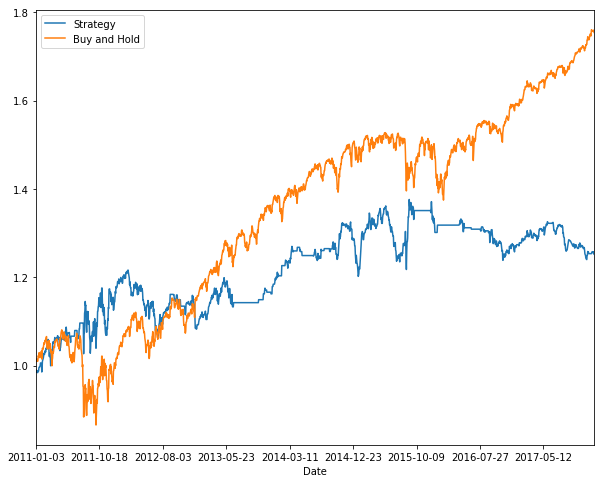

In [47]:
returns = pd.DataFrame(index = signal.index, 
                       columns=['Buy and Hold', 'Strategy'])
returns['Buy and Hold'] = get_logreturns(SPX)[-foreLength:]
returns['Strategy'] = signal*returns['Buy and Hold']
eqCurves = pd.DataFrame(index = signal.index, 
                       columns=['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold']=returns['Buy and Hold'].cumsum()+1
eqCurves['Strategy'] = returns['Strategy'].cumsum()+1
eqCurves['Strategy'].plot(figsize=(10,8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()